In [1]:
!pip install pymorphy3 nltk tqdm catboost wordcloud seaborn fasttext

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-macosx_15_0_universal2.whl size=648773 sha256=99903609d23754beef19d4bc6c23ee6c5f17405ffc74e5483fd826526d5a050c
  Stored in directory: /Users/alposha/Library/Caches/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [fasttext]


In [67]:
from pymorphy3 import MorphAnalyzer
import re
import nltk
from nltk.corpus import stopwords
from tqdm.auto import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import fasttext

# Загрузка данных и очистка

In [5]:
# data = pd.read_csv('/content/drive/My Drive/Anime_reviews_RU.csv')
data = pd.read_csv('Anime_reviews_RU.csv')
data.head()

,Unnamed: 0,Anime,Rate,Text
0,0,Нежный укус / Amagami SS,Нейтральный,"после первой арки несколько разочаровался, ожи..."
1,1,Легенда о легендарных героях / Densetsu no Yuu...,Положительный,"Концовка какая-то мутная, ничего не понял. Над..."
2,2,Мобильный воин Гандам: Единорог / Kidou Senshi...,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х..."
3,3,Невиданный цветок / Ano Hi Mita Hana no Namae ...,Положительный,Только что досмотрел и меня переполняют эмоции...
4,4,Принцесса-медуза / Kuragehime,Положительный,"И правда не оторваться. Но, по-моему, то, что ..."


Удалим ненужные столбцы

In [6]:
data.drop(data.columns[[0, 1]], axis=1, inplace=True)
data.head()

,Rate,Text
0,Нейтральный,"после первой арки несколько разочаровался, ожи..."
1,Положительный,"Концовка какая-то мутная, ничего не понял. Над..."
2,Положительный,"Что тут сказать? Никакого сравнени я с Seed, х..."
3,Положительный,Только что досмотрел и меня переполняют эмоции...
4,Положительный,"И правда не оторваться. Но, по-моему, то, что ..."


Удалим наны

In [7]:
data[data['Text'].isna()]

,Rate,Text
19745,Отрицательный,NaN


In [8]:
data = data.dropna(subset=['Text'])

In [9]:
data[data['Text'].isna()]

,Rate,Text


Проверим на дубликаты

In [10]:
data['Text'].duplicated().sum()

np.int64(50)

In [11]:
data.drop_duplicates(subset=['Text'], inplace=True)

In [13]:
data.duplicated().sum()

np.int64(0)

# Подготовка данных для обучения и разделение на тестовую и обвучающую выбрки

In [ ]:
data['formatted'] = '__label__' + data['Rate'] + ' ' + data['Text']

# Файл для обучения
data[['formatted']].to_csv('train_data.txt', index=False, header=False, sep='\t')

# Обучение модели fastText
model = fasttext.train_supervised(input="train_data.txt", epoch=25, lr=0.1, wordNgrams=2, bucket=100000)

model.save_model("fasttext_model.bin")

Read 14M words
Number of words:  1096988
Number of labels: 3
Progress: 100.0% words/sec/thread: 3381932 lr:  0.000000 avg.loss:  0.309290 ETA:   0h 0m 0s


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Загрузка обученной модели fastText
model_ft = fasttext.load_model('fasttext_model.bin') 

# Получения вектора для текста
def get_fasttext_vector(text, model):
    # Очисстка символов новой строки, если они есть
    text = text.replace("\n", " ")
    return model.get_sentence_vector(text)

X_train = data['Text']
y_train = data['Rate']

# Преобразуем все тексты в вектора с помощью fastText
X_train_fasttext = np.array([get_fasttext_vector(text, model_ft) for text in X_train])

X_train, X_test, y_train, y_test = train_test_split(
    X_train_fasttext,
    y_train,
    test_size=0.2,
    random_state=42)

Добавим код для вывода метрик

In [ ]:
def print_metrics(model, y_test, y_pred):
  print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
  print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
  print(f"Recall:    {recall_score(y_test, y_pred, average='weighted'):.4f}")
  print(f"F1-score:  {f1_score(y_test, y_pred, average='weighted'):.4f}")
  print(classification_report(y_test, y_pred))
  
  cm = confusion_matrix(y_test, y_pred)

  class_labels = model.classes_
  plt.figure(figsize=(6, 5))
  sns.heatmap(
      cm,
      annot=True,
      fmt='d',
      cmap='Blues',
      cbar=True,
      xticklabels=class_labels, 
      yticklabels=class_labels  
)
  plt.title("Матрица ошибок")
  plt.xlabel("Предсказанный класс")
  plt.ylabel("Реальный класс")
  plt.tight_layout()
  plt.show()

# RandomForest с fasttext

Accuracy:  0.8246
Precision: 0.8240
Recall:    0.8246
F1-score:  0.8236
               precision    recall  f1-score   support

  Нейтральный       0.81      0.75      0.78      5118
Отрицательный       0.81      0.82      0.82      3498
Положительный       0.84      0.89      0.86      6017

     accuracy                           0.82     14633
    macro avg       0.82      0.82      0.82     14633
 weighted avg       0.82      0.82      0.82     14633



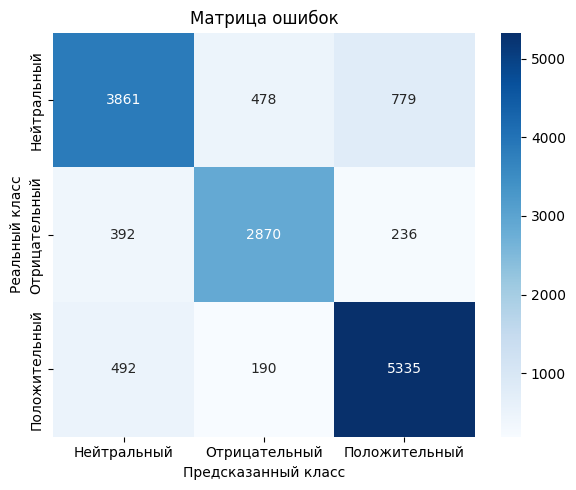

In [86]:
model_rf_ft = RandomForestClassifier(
    n_estimators=200,
    max_depth=200, 
    min_samples_leaf=3,
    random_state=228,
)
model_rf_ft.fit(X_train, y_train)

y_pred = model_rf_ft.predict(X_test)
print_metrics(model_rf_ft, y_test, y_pred)

# LogisticRegression с fasttext

Accuracy:  0.8252
Precision: 0.8247
Recall:    0.8252
F1-score:  0.8245
               precision    recall  f1-score   support

  Нейтральный       0.80      0.77      0.79      5118
Отрицательный       0.84      0.80      0.82      3498
Положительный       0.84      0.88      0.86      6017

     accuracy                           0.83     14633
    macro avg       0.82      0.82      0.82     14633
 weighted avg       0.82      0.83      0.82     14633



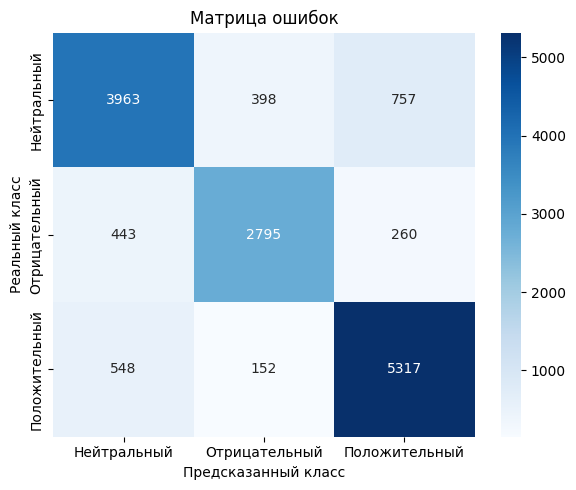

In [63]:
model_lr_ft = LogisticRegression(max_iter=1500)
model_lr_ft.fit(X_train, y_train)

y_pred = model_lr_ft.predict(X_test)

print_metrics(model_lr_ft, y_test, y_pred)

# CatBoost с fastext

0:	learn: 1.0383619	total: 38.9ms	remaining: 11.6s
50:	learn: 0.4517387	total: 993ms	remaining: 4.85s
100:	learn: 0.4296657	total: 1.91s	remaining: 3.76s
150:	learn: 0.4252053	total: 2.83s	remaining: 2.79s
200:	learn: 0.4218862	total: 3.75s	remaining: 1.85s
250:	learn: 0.4183830	total: 4.67s	remaining: 911ms
299:	learn: 0.4147359	total: 5.58s	remaining: 0us
Accuracy:  0.8257
Precision: 0.8254
Recall:    0.8257
F1-score:  0.8246
               precision    recall  f1-score   support

  Нейтральный       0.82      0.75      0.78      5118
Отрицательный       0.81      0.83      0.82      3498
Положительный       0.84      0.89      0.86      6017

     accuracy                           0.83     14633
    macro avg       0.82      0.82      0.82     14633
 weighted avg       0.83      0.83      0.82     14633



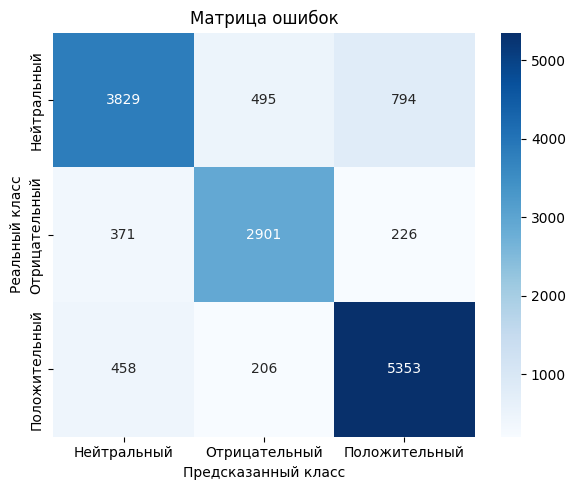

In [90]:
model_cb_ft = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    verbose=50
)

model_cb_ft.fit(X_train, y_train)

y_pred = model_cb_ft.predict(X_test)

print_metrics(model_cb_ft, y_test, y_pred)